# Comparing Lifecycle of `IndSockConsumer` and `MarkovConsumer`
Solutions are comparable (IndShock and Markov are only slightly different from each other)

In [1]:
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks
from HARK.distribution import DiscreteDistributionLabeled
import matplotlib.pyplot as plt
from ConsIndShockModel_HANK import HANKIncShkDstn
# from HARK.utilities import jump_to_grid_1D, jump_to_grid_2D
import numba
from ConsIndShockModel_HANK import IndShockConsumerType 

from TwoSectorModel_HANK import TwoSectorMarkovConsumerType
import numpy as np
from copy import copy, deepcopy

## 1) IndShockConsumer

In [2]:
r_ss = 0.03
Z_ss = 0.7925
T_cycles = 50
cycles = 1

LivPrb = .99375
Z_ss = 0.7925
DiscFac = 0.97
UnempPrb = 0.05

In [3]:
HANK_Dict = {
    "T_cycle": T_cycles,
    "cycles": cycles,
    # Parameters shared with the perfect foresight model
    "Rfree": [1.0 + r_ss] *T_cycles,                    # Interest factor on assets
    "LivPrb" : [LivPrb] *T_cycles,                   # Survival probability
    "DiscFac": DiscFac,

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06]*T_cycles,                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2]*T_cycles,                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    "PermGroFac": [1.01] * T_cycles,
    # HANK params
    "taxrate" : [0.0]*T_cycles, # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss]*T_cycles,
    "wage": [1.0] *T_cycles,    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : [UnempPrb] * T_cycles,                      # Probability of unemployment while working
    "IncUnemp" :  [0.0] * T_cycles,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

In [4]:
# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict['TranShkMean_Func'] = [function] *T_cycles

In [5]:
IndShock_Example = IndShockConsumerType(**HANK_Dict, verbose = False)
IndShock_Example.update()
IndShock_Example.solve()

In [6]:
IndShock_Example.cycles

1

In [7]:
IndShock_Example.T_cycle

50

## MarkovConsumer

In [8]:
# Define the Markov transition matrix for sector f(ormal) to i(nformal)
p_f_to_i = 0.0
p_i_to_f = 0.0
p_f_to_f = 1 - p_f_to_i
p_i_to_i = 1 - p_i_to_f

MrkvArray = np.array(
    [
        [
            p_f_to_f
        ,
            p_f_to_i
        ],
        [
           p_i_to_f
        ,
            p_i_to_i
        ]
    ]
)

NSectors = 2

In [9]:
init_twosector = {
    "cycles" : cycles,
    "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.97,
    "Rfree": np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([0.06, 0.06])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([0.2, 0.2])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([UnempPrb, UnempPrb])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([0.0, 0.0])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([0.0, 0.0])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Z_ss, Z_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([1.0, 1.0])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [0.0, 0.0],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [LivPrb * np.ones(2)] * T_cycles,
    "PermGroFac": [1.01 * np.ones(2)] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [0.5, 0.5],

}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

init_twosector['TranShkMean_Func'] = [function]

In [10]:
TwoSectorExample = TwoSectorMarkovConsumerType(**init_twosector)


In [11]:
### RFREE WITH TIME VARYING
TwoSectorExample.assign_parameters(
    Rfree=[np.array(2 * [1 + r_ss])] * T_cycles
)

In [12]:
TwoSectorExample.solve()

## Compare

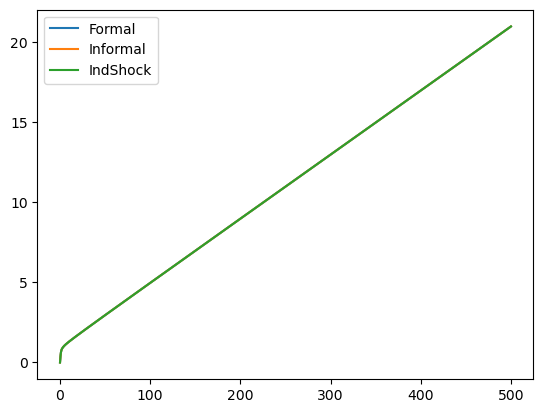

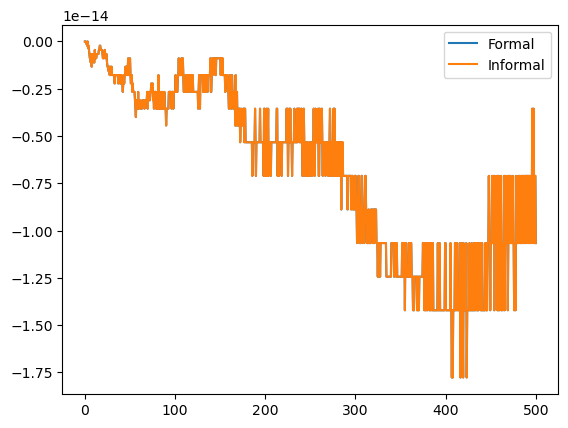

In [13]:
mGrid = np.linspace(0, 500, 1000)
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[0](mGrid), label = 'Formal')
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[1](mGrid), label = 'Informal')
plt.plot(mGrid, IndShock_Example.solution[0].cFunc(mGrid), label = 'IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[0](mGrid) - IndShock_Example.solution[0].cFunc(mGrid), label = 'Formal')
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[1](mGrid) - IndShock_Example.solution[0].cFunc(mGrid), label = 'Informal')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()


# Infinite Horizon

In [14]:
cycles = 0
T_cycles = 1
HANK_Dict_inf = {
    "T_cycle": T_cycles,
    "cycles": cycles,
    # Parameters shared with the perfect foresight model
    "Rfree": [1.0 + r_ss] *T_cycles,                    # Interest factor on assets
    "LivPrb" : [LivPrb] *T_cycles,                   # Survival probability
    "DiscFac": DiscFac,

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06]*T_cycles,                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2]*T_cycles,                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    "PermGroFac": [1.01] * T_cycles,
    # HANK params
    "taxrate" : [0.0]*T_cycles, # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss]*T_cycles,
    "wage": [1.0] *T_cycles,    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : UnempPrb,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict_inf['TranShkMean_Func'] = [function] *T_cycles


In [15]:
IndShock_Inf = IndShockConsumerType(**HANK_Dict_inf)
IndShock_Inf.cycles = 0
IndShock_Inf.update()
IndShock_Inf.solve()

GPFRaw                 = 0.989653 
GPFNrm                 = 0.992854 
GPFAggLivPrb           = 0.983468 
Thorn = APF            = 0.999550 
PermGroFacAdj          = 1.006745 
uInvEpShkuInv          = 0.996777 
VAF                    = 0.960830 
WRPF                   = 0.216317 
DiscFacGPFNrmMax       = 0.984014 
DiscFacGPFAggLivPrbMax = 0.996617 


In [16]:
T_cycles = 1
init_twosector_inf = {
    "cycles" : 0,
    "T_cycle" : 1,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.97,
    "Rfree": np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([0.06, 0.06])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([0.2, 0.2])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([UnempPrb, UnempPrb])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([0.0, 0.0])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([0.0, 0.0])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Z_ss, Z_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([1.0, 1.0])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [0.0, 0.0],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [LivPrb * np.ones(2)] * T_cycles,
    "PermGroFac": [1.01 * np.ones(2)] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [0.5, 0.5],

}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

init_twosector_inf['TranShkMean_Func'] = [function]

In [17]:
TwoSector_Inf = TwoSectorMarkovConsumerType(**init_twosector_inf)
## RFREE WITH TIME VARYING
TwoSector_Inf.assign_parameters(
    Rfree=[np.array(2 * [1 + r_ss])] * T_cycles
)
TwoSector_Inf.update()
TwoSector_Inf.solve()

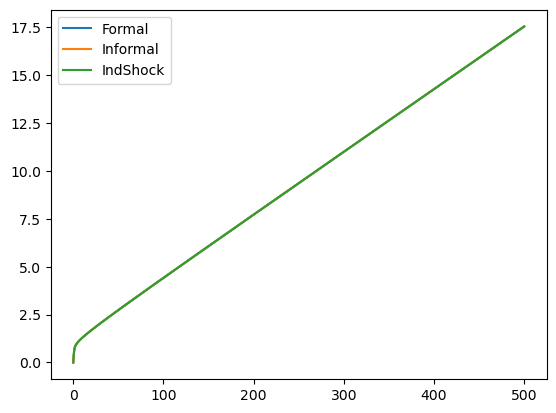

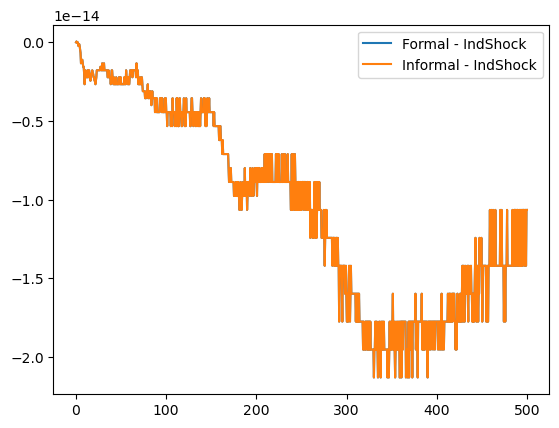

In [18]:
mGrid = np.linspace(0, 500, 1000)
plt.plot(mGrid, TwoSector_Inf.solution[0].cFunc[0](mGrid), label = 'Formal')
plt.plot(mGrid, TwoSector_Inf.solution[0].cFunc[1](mGrid), label = 'Informal')
plt.plot(mGrid, IndShock_Inf.solution[0].cFunc(mGrid), label = 'IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

plt.plot(mGrid, TwoSector_Inf.solution[0].cFunc[0](mGrid) - IndShock_Inf.solution[0].cFunc(mGrid), label = 'Formal - IndShock')
plt.plot(mGrid, TwoSector_Inf.solution[0].cFunc[1](mGrid) - IndShock_Inf.solution[0].cFunc(mGrid), label = 'Informal - IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

# Lifecycle with shock using SS as terminal period

In [19]:
T = 3
shk_param = "Rfree"

In [20]:
Agent_GE_Sec1 = IndShock_Inf

In [21]:
# Set up finite Horizon dictionary
params = deepcopy(Agent_GE_Sec1.__dict__["parameters"])
params["T_cycle"] = T  # Dimension of Jacobian Matrix

# Specify a dictionary of lists because problem we are solving is technically finite horizon so variables can be time varying (see section on fake news algorithm in https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17434 )
params["LivPrb"] = params["T_cycle"] * [Agent_GE_Sec1.LivPrb[0]]
params["PermGroFac"] = params["T_cycle"] * [Agent_GE_Sec1.PermGroFac[0]]
params["PermShkStd"] = params["T_cycle"] * [Agent_GE_Sec1.PermShkStd[0]]
params["TranShkStd"] = params["T_cycle"] * [Agent_GE_Sec1.TranShkStd[0]]
params["Rfree"] = params["T_cycle"] * [Agent_GE_Sec1.Rfree]
params["UnempPrb"] = params["T_cycle"] * [Agent_GE_Sec1.UnempPrb]
params["IncUnemp"] = params["T_cycle"] * [Agent_GE_Sec1.IncUnemp]

params['wage'] = params['T_cycle']*[Agent_GE_Sec1.wage[0]]
params['taxrate'] = params['T_cycle']*[Agent_GE_Sec1.taxrate[0]]
params['labor'] = params['T_cycle']*[Agent_GE_Sec1.labor[0]]
params['TranShkMean_Func'] = params['T_cycle']*[Agent_GE_Sec1.TranShkMean_Func[0]]

# Create instance of a finite horizon agent
FinHorizonAgent_AUX_Sec1 = IndShockConsumerType(**params)
FinHorizonAgent_AUX_Sec1.cycles = 1  # required

# delete Rfree from time invariant list since it varies overtime
FinHorizonAgent_AUX_Sec1.del_from_time_inv("Rfree")
# Add Rfree to time varying list to be able to introduce time varying interest rates
FinHorizonAgent_AUX_Sec1.add_to_time_vary("Rfree")

# Set Terminal Solution as Steady State Consumption Function
# FinHorizonAgent_AUX_Sec1.cFunc_terminal_ = deepcopy(Agent_GE_Sec1.solution[0].cFunc)
FinHorizonAgent_AUX_Sec1.solution_terminal = deepcopy(Agent_GE_Sec1.solution[0])

dx = 0.0001  # Size of perturbation
# Period in which the change in the interest rate occurs (second to last period)
i = params["T_cycle"] - 1

FinHorizonAgent_AUX_Sec1.IncShkDstn = params["T_cycle"] * [Agent_GE_Sec1.IncShkDstn[0]]

# If parameter is in time invariant list then add it to time vary list
FinHorizonAgent_AUX_Sec1.del_from_time_inv(shk_param)
FinHorizonAgent_AUX_Sec1.add_to_time_vary(shk_param)

# this condition is because some attributes are specified as lists while other as floats
if type(getattr(Agent_GE_Sec1, shk_param)) == list:
    peturbed_list = (
        (i) * [getattr(Agent_GE_Sec1, shk_param)[0]]
        + [getattr(Agent_GE_Sec1, shk_param)[0] + dx]
        + (params["T_cycle"] - i - 1) * [getattr(Agent_GE_Sec1, shk_param)[0]]
    )  # Sequence of interest rates the agent faces
else:
    peturbed_list = (
        (i) * [getattr(Agent_GE_Sec1, shk_param)]
        + [getattr(Agent_GE_Sec1, shk_param) + dx]
        + (params["T_cycle"] - i - 1) * [getattr(Agent_GE_Sec1, shk_param)]
    )  # Sequence of interest rates the agent 
    
setattr(FinHorizonAgent_AUX_Sec1, shk_param, peturbed_list)

# Update income process if perturbed parameter enters the income shock distribution
FinHorizonAgent_AUX_Sec1.update_income_process()

# Solve
FinHorizonAgent_AUX_Sec1.solve()

#FinHorizonAgent.Rfree = params["T_cycle"] * [Agent_GE.Rfree]
# Use Harmenberg Neutral Measure
FinHorizonAgent_AUX_Sec1.neutral_measure = True
FinHorizonAgent_AUX_Sec1.update_income_process()

# Calculate Transition Matrices
FinHorizonAgent_AUX_Sec1.define_distribution_grid()
FinHorizonAgent_AUX_Sec1.calc_transition_matrix()

In [22]:
# Set up finite Horizon dictionary
params = deepcopy(TwoSector_Inf.__dict__["parameters"])
params["T_cycle"] = T  # Dimension of Jacobian Matrix
params["cycles"] = 1  # required

# Specify a dictionary of lists because problem we are solving is technically finite horizon so variables can be time varying (see section on fake news algorithm in https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17434 )
params["LivPrb"] = params["T_cycle"] * [TwoSector_Inf.LivPrb[0]]
params["PermGroFac"] = params["T_cycle"] * [TwoSector_Inf.PermGroFac[0]]
params["PermShkStd"] = params["T_cycle"] * [TwoSector_Inf.PermShkStd[0]]
params["TranShkStd"] = params["T_cycle"] * [TwoSector_Inf.TranShkStd[0]]
params["Rfree"] = params["T_cycle"] * [TwoSector_Inf.Rfree[0]]
params["UnempPrb"] = params["T_cycle"] * [TwoSector_Inf.UnempPrb[0]]
params["IncUnemp"] = params["T_cycle"] * [TwoSector_Inf.IncUnemp[0]]

params['wage'] = params['T_cycle']*[TwoSector_Inf.wage[0]]
params['taxrate'] = params['T_cycle']*[TwoSector_Inf.taxrate[0]]
params['labor'] = params['T_cycle']*[TwoSector_Inf.labor[0]]
params['TranShkMean_Func'] = params['T_cycle']*[TwoSector_Inf.TranShkMean_Func[0]]

params["MrkvArray"] = params["T_cycle"] * [TwoSector_Inf.MrkvArray[0]]


In [45]:
FinHorizonAgent = TwoSectorMarkovConsumerType(**params)
# delete Rfree from time invariant list since it varies overtime
FinHorizonAgent.del_from_time_inv("Rfree")
# Add Rfree to time varying list to be able to introduce time varying interest rates
FinHorizonAgent.add_to_time_vary("Rfree")

# Set Terminal Solution as Steady State Consumption Function
FinHorizonAgent.cFunc_terminal_ = deepcopy(TwoSectorExample.solution[0].cFunc)
#FinHorizonAgent.solution_terminal = deepcopy(TwoSector_Inf.solution[0])

dx = 0.0001  # Size of perturbation
# Period in which the change in the interest rate occurs (second to last period)
i = params["T_cycle"] - 1

FinHorizonAgent.IncShkDstn = params["T_cycle"] * [TwoSector_Inf.IncShkDstn[0]]

# If parameter is in time invariant list then add it to time vary list
FinHorizonAgent.del_from_time_inv(shk_param)
FinHorizonAgent.add_to_time_vary(shk_param)

# this condition is because some attributes are specified as lists while other as floats
if type(getattr(TwoSector_Inf, shk_param)) == list:
    peturbed_list = (
        (i) * [getattr(TwoSector_Inf, shk_param)[0]]
        + [getattr(TwoSector_Inf, shk_param)[0] + dx]
        + (params["T_cycle"] - i - 1) * [getattr(TwoSector_Inf, shk_param)[0]]
    )  # Sequence of interest rates the agent faces
else:
    peturbed_list = (
        (i) * [getattr(TwoSector_Inf, shk_param)]
        + [getattr(TwoSector_Inf, shk_param) + dx]
        + (params["T_cycle"] - i - 1) * [getattr(TwoSector_Inf, shk_param)]
    )  # Sequence of interest rates the agent 
    
setattr(FinHorizonAgent, shk_param, peturbed_list)

In [46]:
FinHorizonAgent.update_income_process_Markov()


In [47]:
FinHorizonAgent.solve()

# Compare

IndShock:
- IndShock_Inf
- FinHorizonAgent_AUX_Sec1

Markov:
- TwoSector_Inf
- FinHorizonAgent

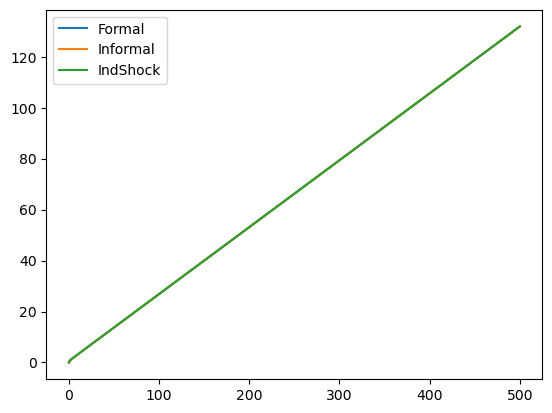

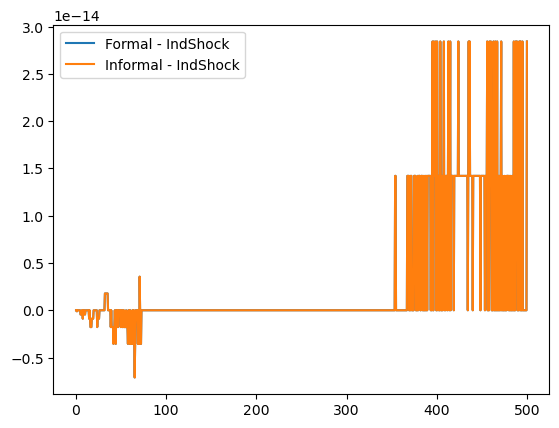

In [48]:
mGrid = np.linspace(0, 500, 1000)
plt.plot(mGrid, FinHorizonAgent.solution[0].cFunc[0](mGrid), label = 'Formal')
plt.plot(mGrid, FinHorizonAgent.solution[0].cFunc[1](mGrid), label = 'Informal')
plt.plot(mGrid, FinHorizonAgent_AUX_Sec1.solution[0].cFunc(mGrid), label = 'IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

plt.plot(mGrid, FinHorizonAgent.solution[0].cFunc[0](mGrid) - FinHorizonAgent_AUX_Sec1.solution[0].cFunc(mGrid), label = 'Formal - IndShock')
plt.plot(mGrid, FinHorizonAgent.solution[0].cFunc[1](mGrid) - FinHorizonAgent_AUX_Sec1.solution[0].cFunc(mGrid), label = 'Informal - IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

### Create MARKOV Problem differently (Give it its own dictionary)

In [27]:
cycles = 1
T_cycles = 300
init_twosector_SSJ = {
    "cycles" : cycles,
    "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.97,
    "Rfree": np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([0.06, 0.06])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([0.2, 0.2])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([UnempPrb, UnempPrb])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([0.0, 0.0])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([0.0, 0.0])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Z_ss, Z_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([1.0, 1.0])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [0.0, 0.0],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [LivPrb * np.ones(2)] * T_cycles,
    "PermGroFac": [1.01 * np.ones(2)] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [0.5, 0.5],

}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

init_twosector_SSJ['TranShkMean_Func'] = [function] * T_cycles

In [28]:
init_twosector_SSJ["Rfree"] = [np.array(2 * [1.0 + r_ss])] * T_cycles
init_twosector_SSJ["Rfree"][-1] = np.array(2 * [1 + r_ss + dx])

In [29]:
FinHorizonAgent_NEW = TwoSectorMarkovConsumerType(**init_twosector_SSJ)

# ## RFREE WITH TIME VARYING
# FinHorizonAgent_NEW.assign_parameters(
#     Rfree=[np.array(2 * [1 + r_ss])] * T_cycles
# )



In [30]:
# FinHorizonAgent_NEW.Rfree[-1] = np.array(2 * [1 + r_ss + 0.5])

In [31]:
FinHorizonAgent_NEW.update_income_process_Markov()

In [32]:
FinHorizonAgent_NEW.Rfree

[array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.03, 1.03]),
 array([1.

In [33]:
FinHorizonAgent_NEW.solution_terminal = deepcopy(TwoSector_Inf.solution[0])


In [34]:
# FinHorizonAgent_NEW.solution_terminal_ = deepcopy(TwoSector_Inf.solution[0])


In [35]:
# FinHorizonAgent_NEW.cFunc_terminal_ = deepcopy(TwoSector_Inf.solution[0].cFunc)

In [36]:
FinHorizonAgent_NEW.solve()

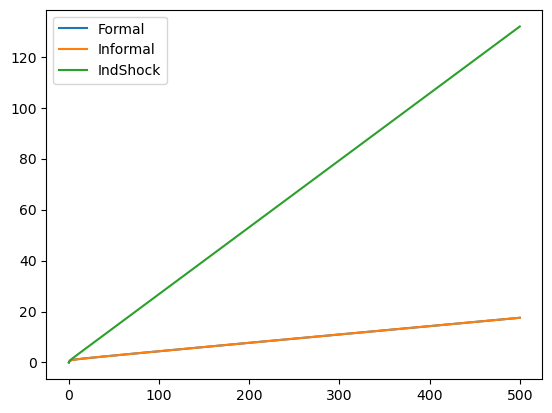

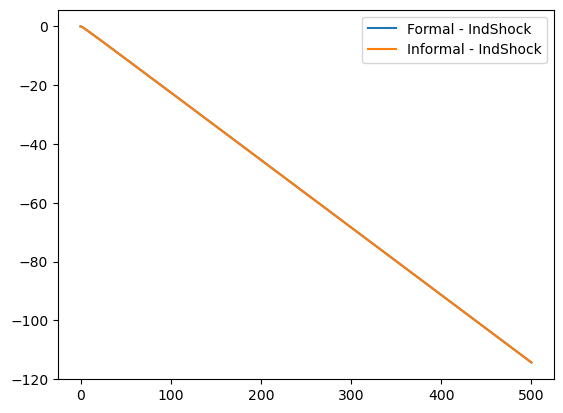

In [37]:
mGrid = np.linspace(0, 500, 1000)
plt.plot(mGrid, FinHorizonAgent_NEW.solution[0].cFunc[0](mGrid), label = 'Formal')
plt.plot(mGrid, FinHorizonAgent_NEW.solution[0].cFunc[1](mGrid), label = 'Informal')
plt.plot(mGrid, FinHorizonAgent_AUX_Sec1.solution[0].cFunc(mGrid), label = 'IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

plt.plot(mGrid, FinHorizonAgent_NEW.solution[0].cFunc[0](mGrid) - FinHorizonAgent_AUX_Sec1.solution[0].cFunc(mGrid), label = 'Formal - IndShock')
plt.plot(mGrid, FinHorizonAgent_NEW.solution[0].cFunc[1](mGrid) - FinHorizonAgent_AUX_Sec1.solution[0].cFunc(mGrid), label = 'Informal - IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

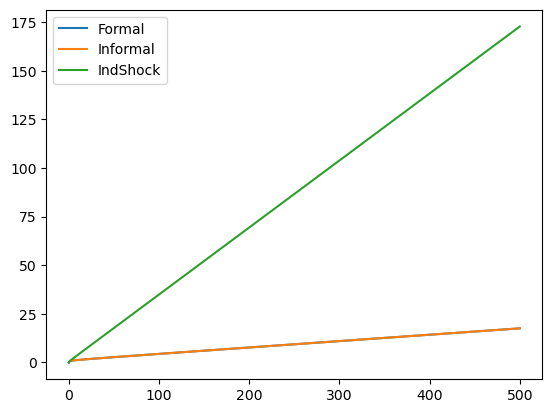

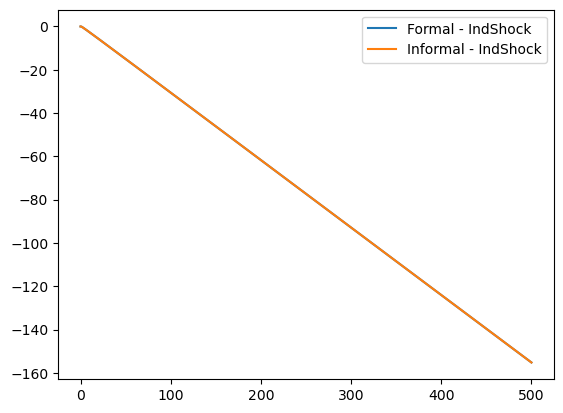

In [38]:
t = -3

plt.plot(mGrid, FinHorizonAgent_NEW.solution[t].cFunc[0](mGrid), label = 'Formal')
plt.plot(mGrid, FinHorizonAgent_NEW.solution[t].cFunc[1](mGrid), label = 'Informal')
plt.plot(mGrid, FinHorizonAgent_AUX_Sec1.solution[t].cFunc(mGrid), label = 'IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

plt.plot(mGrid, FinHorizonAgent_NEW.solution[t].cFunc[0](mGrid) - FinHorizonAgent_AUX_Sec1.solution[t].cFunc(mGrid), label = 'Formal - IndShock')
plt.plot(mGrid, FinHorizonAgent_NEW.solution[t].cFunc[1](mGrid) - FinHorizonAgent_AUX_Sec1.solution[t].cFunc(mGrid), label = 'Informal - IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()